# 📔 READ_ME und TO_DO

#### README

In [2]:
%%writefile '/content/drive/MyDrive/Colab Notebooks/SEO/README.md'
# 🚀 SEO Automation Pipeline mit OpenAI & Retrieval (RAG)

Dieses Projekt bietet eine **komplette End-to-End-Pipeline für die SEO-Optimierung von Websites**, inklusive **Web-Scraping, SEO-Analyse, KI-gestützter Text-Optimierung und Qualitätskontrolle**.

Kern des Projekts sind **automatisierte Abläufe**, die von der **Datengewinnung bis zur SEO-optimierten Textgenerierung** reichen.
Mithilfe von **OpenAI (ChatGPT)** und einer **Retrieval Augmented Generation (RAG)-Architektur** wird sichergestellt, dass die finalen Texte nicht nur **SEO-freundlich**, sondern auch **grammatikalisch korrekt und hochwertig** sind.

## 📚 Inhaltsverzeichnis

- Features
- Projektstruktur
- Ablauf & Module
- Technologien
- Installation
- Nutzung
- Ziele
- Roadmap

## ✅ Features

- 🌐 **Automatisiertes Web Scraping** (inkl. Filter für relevante Inhalte)
- ✍️ **Generierung von SEO-optimierten Texten** mithilfe der OpenAI API
- 🧠 **RAG-gestützte Fehlererkennung & Textkorrektur** mit Vektordatenbank (FAISS)
- 📊 **Analyse der Optimierungsergebnisse** (Statistiken, Ähnlichkeiten, Visualisierungen)
- 📈 **Keyword-Analyse und Keyword-Optimierung**
- 📦 Ausgabe in **HTML und PDF** für Kunden
- 📊 Umfangreiche **Datenvisualisierungen** (Wordclouds, Cosine Similarity, Keyword-Verteilung)




<img src="https://drive.google.com/uc?id=10oR2bcugvN2MClp14ia7gnzMGX5b896t" alt="SEO Heatmap" width="600">




## 🗂️ Projektstruktur

```
SEO-Project/
├── data/                # Prompts, Fehler-Korrektur-Daten, weitere JSON Dateien
├── notebooks/           # Colab/Notebooks zum Starten und Entwickeln
├── src/                # Source Code (Python-Klassen und Module)
│   ├── webscraper.py    # Webscraping und Text-Extraktion
│   ├── llm_processor.py # Anbindung an OpenAI API, Keyword Extraktion
│   ├── chatbot.py       # Zentrale Chatbot-Klasse zur Kommunikation mit GPT
│   ├── seoanalyzer.py   # Analyse und Auswertung der Texte
│   ├── github.py        # Automatischer Upload ins GitHub Repo
│   ├── rag_checker.py   # RAG-Modul für Fehlerkorrektur via FAISS
│   ├── utils.py         # Hilfsmodule (z.B. für Prompt-Management)
│   └── embedding_demo.py# 3D Embedding- und Cosine Similarity Visualisierungen
└── requirements.txt    # Python-Abhängigkeiten
```

## ⚙️ Ablauf & Module

### 1. **Web Scraping**
- **src/webscraper.py**: Holt Inhalte von Webseiten, filtert irrelevante Seiten (z.B. Impressum, AGB).

### 2. **SEO-Optimierung mit OpenAI**
- **src/llmprocessor.py**:
  - Extrahiert Keywords aus den Inhalten.
  - Optimiert die Texte für SEO mit gezielten Prompts.

### 3. **Analyse & Visualisierung**
- **src/seoanalyzer.py**: Verarbeitet und analysiert die Original- und optimierten Texte.

### 4. **GitHub Automation**
- **src/github.py**: Lädt finale Ergebnisse in ein GitHub-Repo hoch.

## 🧰 Technologien

| Technologie                  | Beschreibung                                       |
|-----------------------------|---------------------------------------------------|
| Python                      | Hauptsprache                                       |
| OpenAI API (ChatGPT, GPT-4)  | Generative KI für SEO-Texte                       |
| FAISS                      | Vektorsuche für RAG und Text-Fehler                |
| Pandas, NumPy               | Datenanalyse und Verarbeitung                      |
| Matplotlib, Seaborn         | Visualisierungen                                   |
| Sentence Transformers       | Embedding-Erstellung für Vektordatenbank          |
| BeautifulSoup, Requests     | Webscraping                                        |
| Google Colab                | Entwicklung und Ausführung                        |

## 🚀 Installation

```bash
pip install -r requirements.txt
python -m spacy download de_core_news_sm
pip install faiss-cpu sentence-transformers openai wordcloud matplotlib seaborn
```

## 💻 Nutzung

```python
scraper = WebsiteScraper(start_url="https://www.example.com")
scraper.scrape_website()

llm_processor = LLMProcessor(prompts_folder, get_filtered_texts, google_ads_keywords)
llm_processor.run_all()

seo_analyzer = SEOAnalyzer(seo_json, original_texts, keywords_final)
seo_analyzer.run_analysis()
```

## 🎯 Ziele

- ✅ Vollständige Automatisierung der SEO-Optimierung
- ✅ RAG für sprachliche Qualitätskontrolle
- ✅ Kundenfertige PDF/HTML-Reports

## 🚧 Roadmap

- [ ] Automatische SEO Scores (z.B. Google Ads API)
- [ ] Automatische Keyword-Erweiterung
- [ ] Mehrsprachigkeit (aktuell Deutsch)
- [ ] WordPress-Integration


Overwriting /content/drive/MyDrive/Colab Notebooks/SEO/README.md


####TODO

In [3]:
%%writefile '/content/drive/MyDrive/Colab Notebooks/SEO/TODO.md'
# To-Do Liste: SEO Automation & KI-Projekt

Diese Liste fasst alle anstehenden Aufgaben im Projekt zusammen

---

## 0. **Aktuelles und dringendes**
- [ ] 18.3.2025 **Version missmatch**: numpy 2.2.3 und spacy 3.5 **side effects on**: dependencies.py, excelimporter.py, Installation.ipynb **ursachen**: spacy version 3.5 verlangt numpy 1.26.4 -> version missmatch
      -> 23.5. class SEOAnlyzer refaktoriert und spacy ersetzt
- [ ] 24.3.25 class **webscraper** meta titel?
- [ ] 28.3.25 lokale SEO keywords liefern manchmal falsche Stadt

---

## 1. **Allgemeine Projektorganisation**
- [ ] **Projektstruktur verbessern**: Ordner übersichtlich gestalten (z.B. `src/`, `data/`, `tests/`, `notebooks/`, dependencies.py).
- [ ] **Dokumentation erweitern**: READ_ME und Wiki (bzw. GitHub Pages) zu jedem Modul anlegen.
- [ ] **Automatisierte Tests** Pytest für Kernfunktionen ausbauen.
- [ ] **Produkt für Kunden finalisieren**
- [ ] **FAISS DB**: automatisierte Erweiterung bei neu gefundenen Fehlern
- [ ] **Template GitHub**: issues
- [ ] Funktionalitäten aus **utils.py** überdenken
- [ ] langfristig Umstieg auf **langchain**
- [ ] textprocessor durch openai **function calling** ersetzen
- [ ] **dependencies** und versionen robuster machen
- [ ] **bug reporting system** einrichten

---

## 2. **Vector-Datenbank (FAISS) & Retrieval**
- [ ] **VectorDB-Klasse finalisieren**:
  - [ ] Kleinere Bugs beheben
  - [ ] Userfreundliche Methoden für neue Einträge
- [ ] **Einrichtung der DB** bei Projektstart (Neubau vs. Laden) vereinheitlichen
- [ ] **Konfigurierbare Ähnlichkeits-Schwelle** (z.B. `threshold=0.6`) besser dokumentieren
- [ ] **Dynamische Filter** für bestimmte Fehlerkategorien (z.B. Stil vs. Grammatik) überlegen
- [ ] **hybrides system mit knowledge tree und RAG** etablieren

---

## 3. **SEO-Optimierungs-Pipeline (LangChain)**
- [ ] **Prompts in JSON-Dateien** verlagern (z.B. `/data/prompts/`) und sauber verlinken
- [ ] **Supervisor-Feedback** integrieren & QA-Schritte definieren

---

## 4. **SEOGrammarChecker & PromptManager**
- [ ] Klassenrefactoring:
  - [ ] **`VectorDB`** vs. **`PromptManager`** vs. **`SEOGrammarChecker`** sauber trennen
  - [ ] Möglichst wenig Code-Duplikate, mehr modulare Testbarkeit
- [ ] **Konfigurationsdatei** (z.B. YAML) für Pfade, wie `FAISS_PATH` & Promptordner
- [ ] **Erweiterbare Prompt-Templates**:
  - [ ] Z.B. `seo_optimization.json`, `grammar_check.json`, `supervisor.json`, etc.

---

## 5. **Abschluss & Integration**
- [ ] **Dokumentation** aller Pipelines & Klassen in der README (oder in separater Doku)
- [ ] **Optionale WordPress-Integration** in der Zukunft (Ideenspeicher)
  - [ ] Upload via REST API
  - [ ] Metadaten (Title, Slug, Tags etc.)


Overwriting /content/drive/MyDrive/Colab Notebooks/SEO/TODO.md


#🌋HYPERPARAMETER



In [4]:
### HYPERPARAMETER ###

from google.colab import drive, userdata
drive.mount('/content/drive', force_remount=True)

PROJECT_ROOT = userdata.get("gdrive_seo_root")
PROJECT_ROOT_ESC_STR = PROJECT_ROOT.replace('Colab Notebooks', 'Colab\ Notebooks')

SRC_PATH, DATA_PATH, TEST_PATH, OUTPUT_PATH = PROJECT_ROOT + "/src", PROJECT_ROOT + "/data", PROJECT_ROOT + '/tests', PROJECT_ROOT + '/output'
FAISS_PATH = DATA_PATH + '/faiss_db'
KEYWORD_PATH = DATA_PATH + '/keywords'
PROMPT_PATH = DATA_PATH + '/prompts'

# START_URL = 'https://www.ewms-tech.com/'
START_URL = "https://www.rue-zahnspange.de/"
# START_URL = 'https://www.malerarbeiten-koenig.de/'
EXCLUDED_WEBSITES = ["impressum", "datenschutz", "datenschutzerklärung", "agb"]


Mounted at /content/drive


# 🏁 Install requirements

In [5]:
%run '/content/drive/MyDrive/Colab Notebooks/SEO/notebooks/Installation.ipynb'

In [6]:
# %run '/content/drive/MyDrive/Colab Notebooks/SEO/src/dependencies.py'

# ⛩ push to github

In [7]:
import importlib
import github
importlib.reload(github)
from github import GitHubManager

# Starte den GitHub-Sync
git_manager = GitHubManager(
    userdata.get("github_pat"),
    userdata.get("github_email"),
    userdata.get("github_username"),
    userdata.get("github_repo_seo"),
    PROJECT_ROOT_ESC_STR
)

git_manager.clone_repo()  # Klonen des Repos
git_manager.sync_project()

📥 Klonen des GitHub-Repositories...
📂 Kopiere das Projekt ins Repository...
🔧 Git-Konfiguration wird gesetzt...
➕ Änderungen hinzufügen...
📌 Änderungen committen...
⬆️ Änderungen werden auf GitHub gepusht...
✅ Repository erfolgreich synchronisiert!


# 🕸 scrap

In [8]:
import importlib
import webscraper
importlib.reload(webscraper)
from webscraper import WebsiteScraper

scraper = WebsiteScraper(start_url=START_URL, max_pages=20, excluded_keywords=EXCLUDED_WEBSITES)

original_texts = scraper.get_filtered_texts()

# 📺 google ads seo keywords

In [9]:
import excelimporter
importlib.reload(excelimporter)
from excelimporter import ExcelImporter

importer = ExcelImporter(project_folder=PROJECT_ROOT, header=2)
keyword_df = importer.import_all()

if keyword_df is not None:
    excluded_seo_keywords = ['spange de', 'kfo zentrum essen', 'gerade zahne', 'zahn spange']

    keyword_df = keyword_df[(keyword_df['Avg. monthly searches'] > 10) &
    (~keyword_df['Keyword'].isin(excluded_seo_keywords))
    ].sort_values(by='Avg. monthly searches', ascending=False).reset_index(drop=True).copy()

    google_ads_keywords = list(keyword_df['Keyword'])
else:
    print("Error: importer.import_all() returned None. Check your data file and ExcelImporter class.")
    google_ads_keywords = []

✅ Geladen: /content/drive/MyDrive/Colab Notebooks/SEO/data/keywords/Keyword Stats 2025-03-09 at 12_41_38.xlsx


ℹ️ Logarithmische Skalierung aktiviert.
✅ Heatmap gespeichert als: /content/drive/MyDrive/Colab Notebooks/SEO/output/heatmap_202503.png


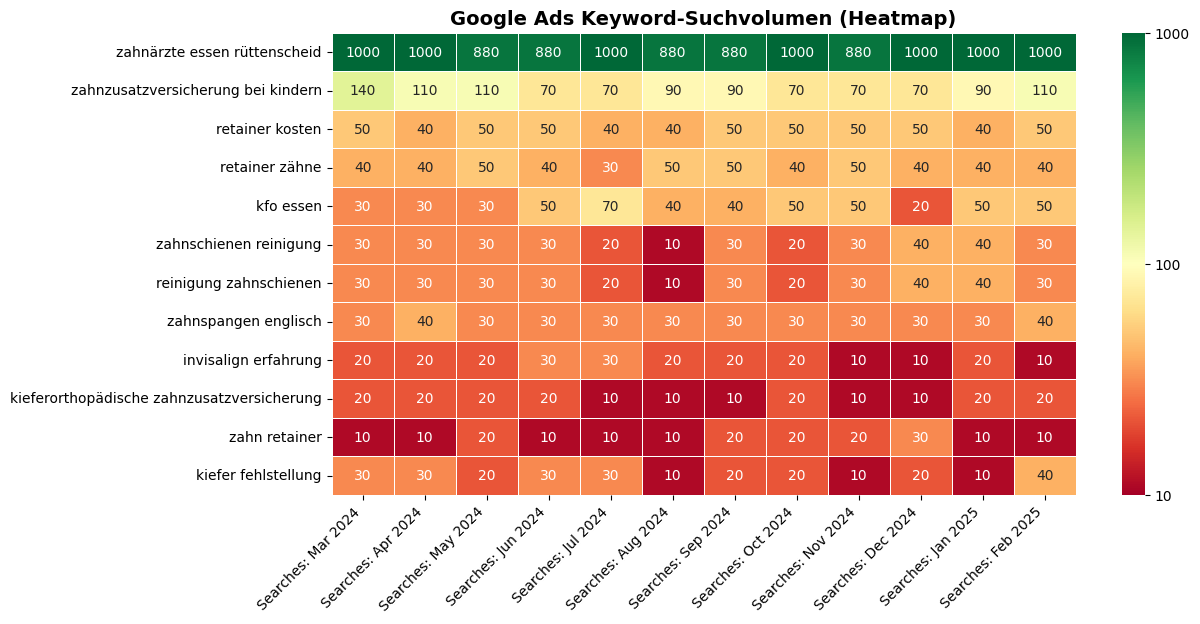

'/content/drive/MyDrive/Colab Notebooks/SEO/output/heatmap_202503.png'

In [10]:
import keywordvisualizer
importlib.reload(keywordvisualizer)
from keywordvisualizer import KeywordVisualizer

keyword_df.set_index(keyword_df.columns[0], inplace=True)
searches_df = keyword_df[[col for col in keyword_df.columns if col.startswith('Searches')]]
visualizer = KeywordVisualizer(searches_df, OUTPUT_PATH)
visualizer.heatmap()

# 🔮webtext analysis + SEO

In [11]:
import llmprocessor
importlib.reload(llmprocessor)
from llmprocessor import LLMProcessor

google_ads_keywords = None if not google_ads_keywords else google_ads_keywords

llm_processor = LLMProcessor(PROMPT_PATH, original_texts, google_ads_keywords=google_ads_keywords)

optimized_texts = llm_processor.run_all()

✅ Google Ads Keywords werden verwendet. LLM Keyword Extraktion wird übersprungen.
📍 Stadt für SEO-Kontext wird via LLM ermittelt...
🚀 Starte SEO-Optimierung mit LLM...

=== SEO-Optimierung für https://www.rue-zahnspange.de/ ===
Analyse  
Der aktuelle Text hat ein gut strukturiertes Layout und bietet umfassende Informationen zu den angebotenen kieferorthopädischen Behandlungen. Dennoch gibt es mehrere Möglichkeiten zur Verbesserung der SEO-Optimierung, um die Sichtbarkeit in Suchmaschinen zu erhöhen. Einige der verwendeten Schlüsselwörter, insbesondere die spezifischen lokalen Begriffe wie "zahnärzte essen rüttenscheid", müssen besser integriert werden. Zudem sollten Longtail-Keywords wie "kieferorthopädische zahnzusatzversicherung" und "retainer kosten" in relevante Abschnitte eingefügt werden. Die Lesbarkeit ist insgesamt gut, jedoch könnte durch die Variation in Satzstrukturen und der strategischen Platzierung von Keywords die Natürlichkeit der Sprache gesteigert werden. Die FAQs sin

# 📁 Textprozessor

In [12]:
import json
import textprocessor
importlib.reload(textprocessor)
from textprocessor import TextProcessor

# JSON mit den SEO-Abschnitten extrahieren
json_output = TextProcessor.extract_sections_to_json(list(optimized_texts.keys()), list(optimized_texts.values()))
seo_json = json.loads(json_output)

# texte bereinigen und hinzufügen
seo_json = TextProcessor.add_cleaned_text(seo_json, original_texts)

# Ergebnis anzeigen
print(json.dumps(seo_json, indent=4, ensure_ascii=False))


{
    "https://www.rue-zahnspange.de/": {
        "Analyse": "Der aktuelle Text hat ein gut strukturiertes Layout und bietet umfassende Informationen zu den angebotenen kieferorthopädischen Behandlungen. Dennoch gibt es mehrere Möglichkeiten zur Verbesserung der SEO-Optimierung, um die Sichtbarkeit in Suchmaschinen zu erhöhen. Einige der verwendeten Schlüsselwörter, insbesondere die spezifischen lokalen Begriffe wie zahnärzte essen rüttenscheid, müssen besser integriert werden. Zudem sollten Longtail-Keywords wie kieferorthopädische zahnzusatzversicherung und retainer kosten in relevante Abschnitte eingefügt werden. Die Lesbarkeit ist insgesamt gut, jedoch könnte durch die Variation in Satzstrukturen und der strategischen Platzierung von Keywords die Natürlichkeit der Sprache gesteigert werden. Die FAQs sind nützlich, könnten aber gezielt mit Keywords versehen werden, um die Relevanz und Sichtbarkeit zu erhöhen.",
        "SEO": "Moderne Zahnspangen in Essen-Rüttenscheid für ein gesünd

# 🔎 SEO Analyses + Statistics

In [13]:
  import nltk
  nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


🔍 Ähnlichkeitsanalyse gestartet...
📊 Similarities (Original -> Keywords): [0.0071628  0.04159651 0.01953409 0.09667651 0.00846574 0.02451209
 0.02451209 0.11317498 0.05014317 0.02282658 0.09667651 0.0240672 ]
📊 Similarities (Optimiert -> Keywords): [0.03004251 0.08186803 0.05126632 0.10590894 0.01832791 0.05079352
 0.05079352 0.12504265 0.04885059 0.05422283 0.10590894 0.02358943]
✅ Plot gespeichert: /content/drive/MyDrive/Colab Notebooks/SEO/output/similarity_scores_202503.png


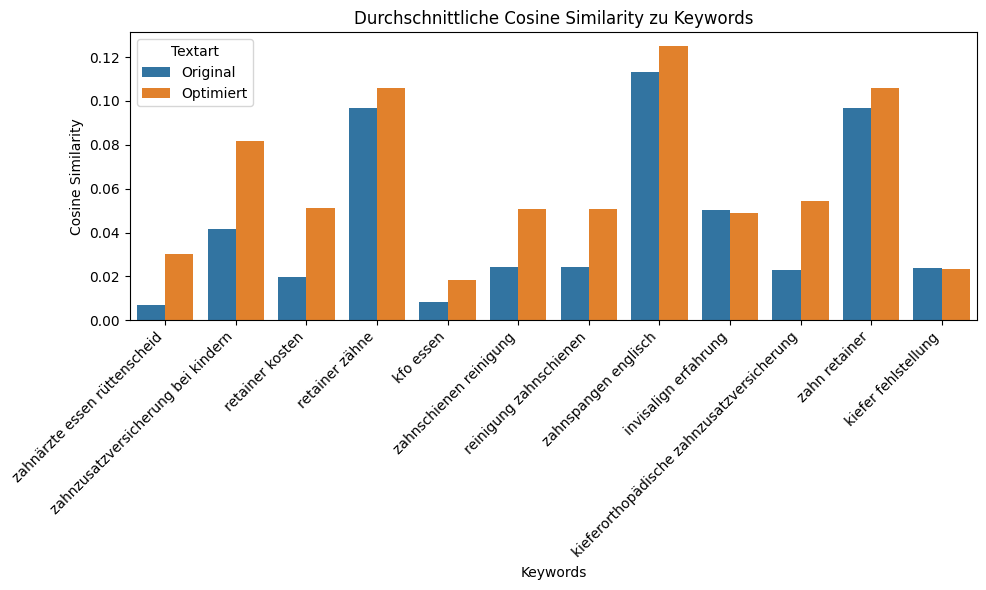

✅ Plot gespeichert: /content/drive/MyDrive/Colab Notebooks/SEO/output/wordclouds_filtered_202503.png


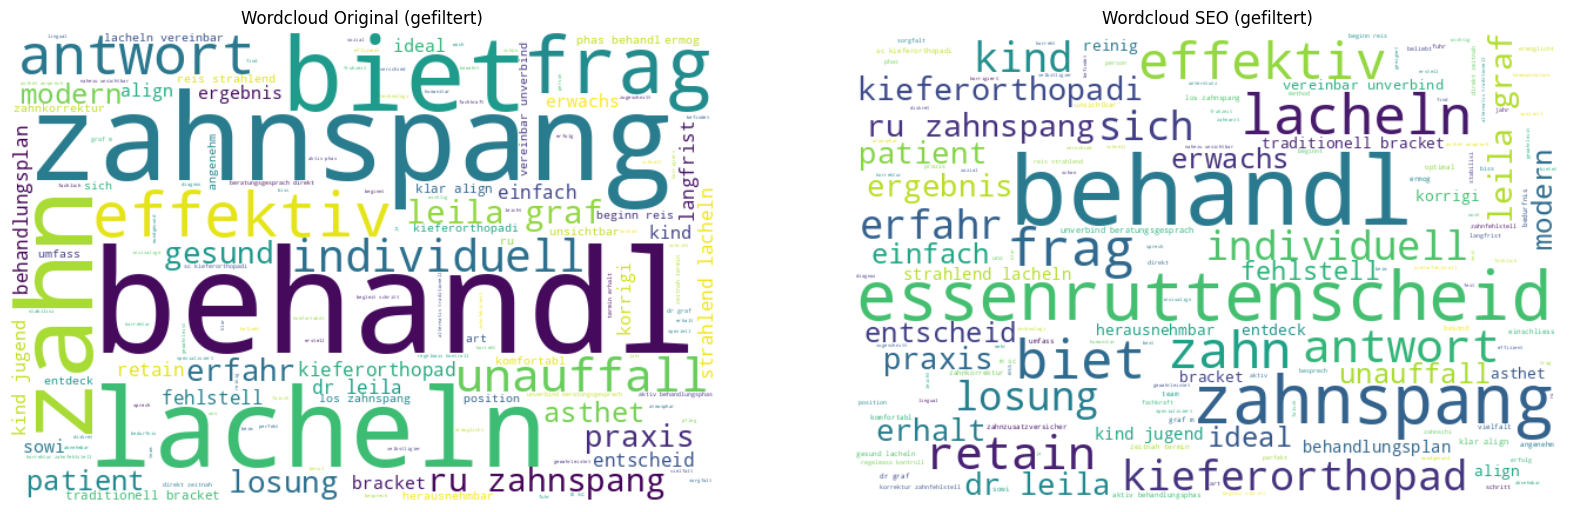

✅ Plot gespeichert: /content/drive/MyDrive/Colab Notebooks/SEO/output/wordclouds_raw_202503.png


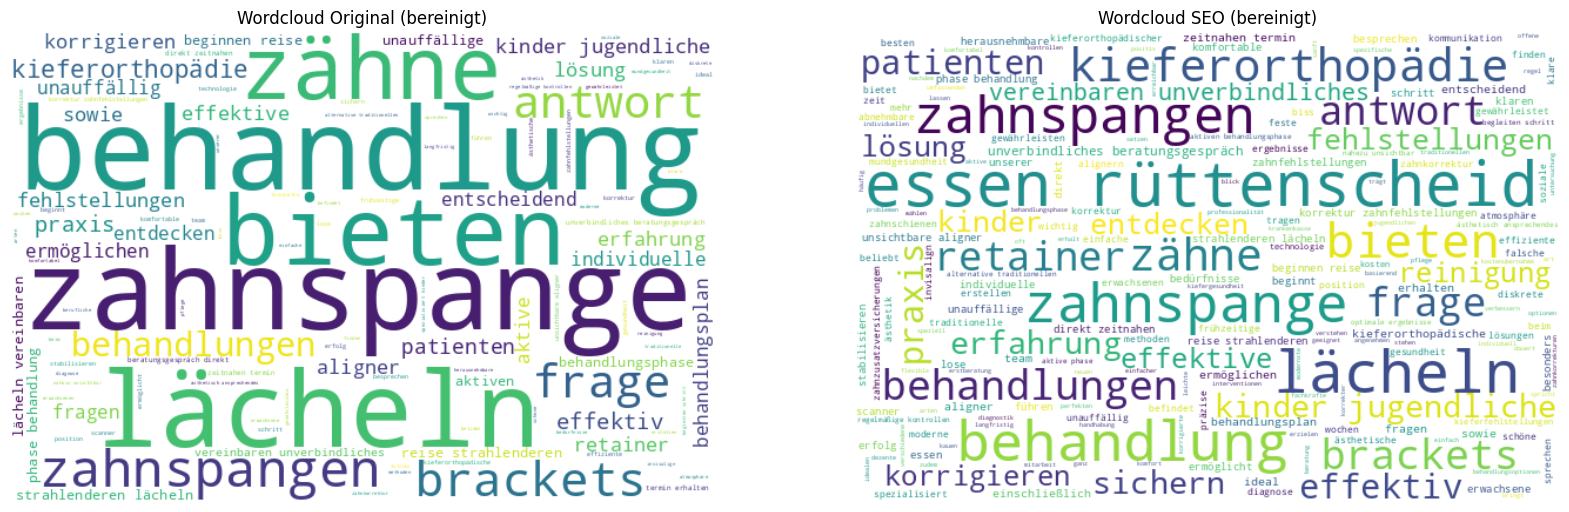

In [14]:
import seoanalyzer
importlib.reload(seoanalyzer)
from seoanalyzer import SEOAnalyzer

exclude_list = ["leila", "graf", "koenig", "bjoern", "könig", 'björn', 'adolf', 'schmidt', 'strasse', 'straße', 'tilo', 'remhof']

keywords_final = json.loads(llm_processor.get_keywords()['keywords_final']) if not google_ads_keywords else google_ads_keywords
seo_analyzer = SEOAnalyzer(seo_json, keywords_final, output_dir=OUTPUT_PATH, wordcloud_exclude=exclude_list)
seo_analyzer.run_analysis()


# ▶◀ conversion rates, modelierungen

In [15]:
# Historische SEO-Daten
historical_data = {
    "Date": [
        "2023-01-01", "2023-02-01", "2023-03-01",
        "2023-04-01", "2023-05-01", "2023-06-01"
    ],
    "Organic_Sessions": [200, 220, 250, 400, 450, 480],
    "Conversion_Rate": [0.02, 0.021, 0.022, 0.028, 0.03, 0.031],
    "Average_Time_on_Page": [40, 42, 45, 60, 65, 70]
}

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


📊 Starte Modellanalysen...
✅ Plot gespeichert: /content/drive/MyDrive/Colab Notebooks/SEO/output/seo_trends_202503.png


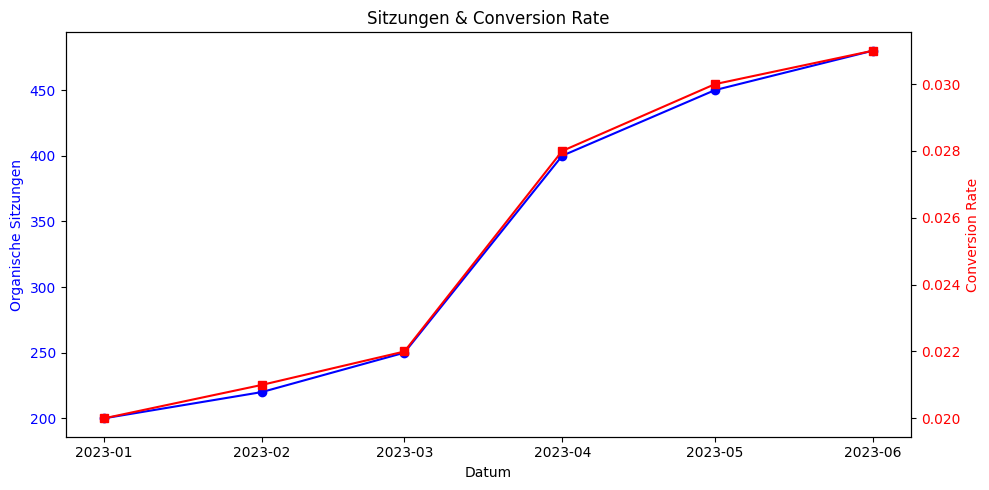

✅ Plot gespeichert: /content/drive/MyDrive/Colab Notebooks/SEO/output/session_forecast_202503.png


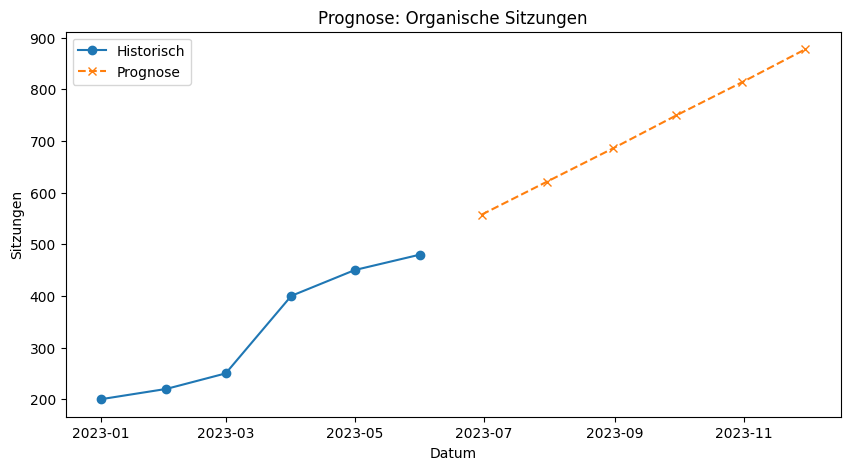

✅ Plot gespeichert: /content/drive/MyDrive/Colab Notebooks/SEO/output/conversion_forecast_202503.png


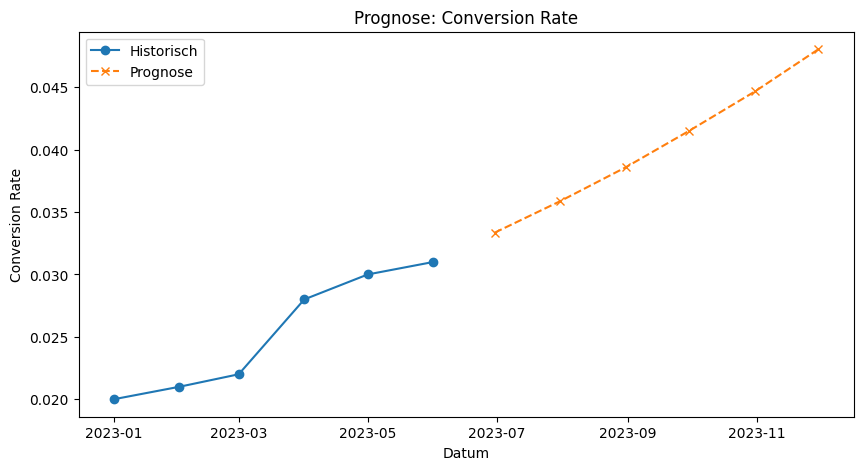

In [16]:
import seoanalyzer
importlib.reload(seoanalyzer)
from seoanalyzer import SEOAnalyzer

seo_analyzer = SEOAnalyzer(seo_json, keywords_final, output_dir=OUTPUT_PATH, historical_data=historical_data) # Added output_dir & historical_data keyword arguments
seo_analyzer.run_models()

# 🛏 embedding demo

In [ ]:
import embeddingdemo
importlib.reload(embeddingdemo)
from embeddingdemo import EmbeddingDemo

demo = EmbeddingDemo(output_dir="output")
demo.run_all_visualizations()


# ⛳ json to pdf + docx

In [ ]:
from jinja2 import Template

def json_to_html(seo_json, sections_intro, image_paths):
    html_template = """
    <!DOCTYPE html>
    <html lang="de">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Website Analyse</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                margin: 30px;
                line-height: 1.6;
                color: #333;
            }
            h1, h2 {
                text-align: center;
                color: #2c3e50;
            }
            .section {
                margin-bottom: 30px;
            }
            .img-block {
                text-align: center;
                margin: 20px 0;
            }
            .img-block img {
                max-width: 90%;
                height: auto;
                border-radius: 8px;
                box-shadow: 0 0 10px rgba(0,0,0,0.1);
            }
            .url {
                font-size: 1.2em;
                font-weight: bold;
                color: #007BFF;
                margin-bottom: 10px;
            }
            .header {
                font-size: 1.1em;
                font-weight: bold;
                color: #555;
                margin-bottom: 10px;
            }
            .content {
                white-space: normal;
                margin-bottom: 20px;
            }
            .column {
                border: 1px solid #ccc;
                padding: 10px;
                box-sizing: border-box;
                background-color: #f9f9f9;
                margin-top: 20px;
            }
            .page-break {
                page-break-after: always;
            }
        </style>
    </head>
    <body>
        <h1>SEO Analyse & Optimierungsreport</h1>

        <!-- 🔹 EINLEITUNGSTEILE -->
        <div class="section">
            <h2>1. Semantische Beziehungen in Vektor-Räumen</h2>
            <p class="content">{{ intro.embedding_text | safe }}</p>
            <div class="img-block">
                <img src="{{ images.embedding_demo }}" alt="BERT Embedding Visualisierung">
            </div>
        </div>

        <div class="section">
            <h2>2. Keyword-Recherche mit Google Ads</h2>
            <p class="content">{{ intro.keyword_text | safe }}</p>
            <div class="img-block">
                <img src="{{ images.google_ads_heatmap }}" alt="Keyword Heatmap aus Google Ads">
            </div>
        </div>

        <div class="section">
            <h2>3. Cosine Similarity erklärt</h2>
            <p class="content">{{ intro.similarity_text | safe }}</p>
            <div class="img-block">
                <img src="{{ images.cosine_similarity_demo }}" alt="Cosine Similarity Plot">
            </div>
        </div>

        <div class="section">
            <h2>4. Keyword-Abdeckung & Analyse</h2>
            <p class="content">{{ intro.keyword_analysis_text | safe }}</p>
            <div class="img-block">
                <img src="{{ images.wordclouds }}" alt="Wordclouds">
            </div>
            <div class="img-block">
                <img src="{{ images.similarity_bars }}" alt="Keyword Similarity Balken">
            </div>
        </div>

        <div class="page-break"></div>

        <!-- 🔹 INDIVIDUELLE WEBSITE-SEKTIONEN -->
        {% for url, sections in seo_json.items() %}
        <div class="section">
            <p class="url">🌐 Website: {{ url }}</p>

            <p class="header">🔍 Analyse</p>
            <p class="content">
                {{ sections.Analyse | replace('\\n','<br>') | safe }}
            </p>

            <p class="header">🧠 Erklärung</p>
            <p class="content">
                {{ sections.Erklärung | replace('\\n','<br>') | safe }}
            </p>

            <div class="column">
                <p class="header">🚀 SEO-Text</p>
                <p class="content">
                    {{ sections.SEO | replace('\\n','<br>') | safe }}
                </p>
            </div>
        </div>
        <div class="page-break"></div>
        {% endfor %}
    </body>
    </html>
    """
    template = Template(html_template)
    return template.render(seo_json=seo_json, intro=sections_intro, images=image_paths)


In [ ]:
sections_intro = {
    "embedding_text": "In Vektor-Räumen können Wörter wie 'König' und 'Königin' durch ähnliche Abstände dargestellt werden. Ein typisches Beispiel: König - Mann + Frau ≈ Königin.",
    "keyword_text": "Die Auswahl der Keywords basiert auf einer Heatmap aus Google Ads – sortiert nach Relevanz und Suchvolumen.",
    "similarity_text": "Cosine Similarity misst den Winkel zwischen zwei Vektoren. Je näher der Winkel bei 0°, desto ähnlicher sind die Inhalte.",
    "keyword_analysis_text": "Die finale Analyse zeigt die Häufigkeit & semantische Nähe der Keywords im SEO-Text."
}
image_paths = {
    "embedding_demo": "images/embedding_demo.png",
    "google_ads_heatmap": "images/heatmap_keywords.png",
    "cosine_similarity_demo": "images/cosine_similarity_plot.png",
    "wordclouds": "images/wordclouds_raw_20250328.png",
    "similarity_bars": "images/similarity_scores_20250328.png"
}


In [ ]:
OUTPUT_PATH

In [ ]:
from jinja2 import Template

def json_to_html(json_data):
    html_template = """
    <!DOCTYPE html>
    <html lang="de">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Website Analyse</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                margin: 20px;
                line-height: 1.6;
            }
            h1 {
                text-align: center;
                color: #333;
            }
            .section {
                margin-bottom: 20px;
            }
            .url {
                font-size: 1.2em;
                font-weight: bold;
                color: #007BFF;
                margin-bottom: 10px;
            }
            .header {
                font-size: 1.1em;
                font-weight: bold;
                color: #555;
                margin-bottom: 10px;
            }
            .content {
                white-space: normal;
                margin-bottom: 20px;
            }
            .column {
                border: 1px solid #ccc;
                padding: 10px;
                box-sizing: border-box;
            }
            /* Zeilenumbrüche aus dem JSON in <br> wandeln */
            .page-break {
                page-break-after: always;
            }
        </style>
    </head>
    <body>
        <h1>Website Analyse & SEO</h1>

        {% for url, sections in data.items() %}
        <div class="section">
            <!-- Website-URL -->
            <p class="url">Website: {{ url }}</p>

            <!-- "Analyse" normal untereinander -->
            <p class="header">Analyse</p>
            <p class="content">
                {{ sections.Analyse | replace('\\n','<br>') | safe }}
            </p>

            <!-- "Erklärung" normal untereinander -->
            <p class="header">Erklärung</p>
            <p class="content">
                {{ sections.Erklärung | replace('\\n','<br>') | safe }}
            </p>

            <!-- NUR noch die "SEO"-Spalte -->
            <div class="column">
                <p class="header">SEO</p>
                <p class="content">
                    {{ sections.SEO | replace('\\n','<br>') | safe }}
                </p>
            </div>
        </div>
        <div class="page-break"></div>
        {% endfor %}
    </body>
    </html>
    """
    template = Template(html_template)
    return template.render(data=json_data)


html_output = json_to_html(seo_json)

# Speichere das HTML
gdrive_seo_folder = userdata.get('gdrive_seo_folder')
with open("/content/drive/MyDrive/" + gdrive_seo_folder + "/output/preview.html", "w", encoding="utf-8") as file:
    file.write(html_output)


In [ ]:
import asyncio
from playwright.async_api import async_playwright

async def html_to_pdf_playwright(html_input, output_file):
    """
    Nutzt das Headless Chromium von Playwright, um die HTML-Datei zu rendern
    und anschließend als PDF zu speichern.
    """
    async with async_playwright() as p:
        browser = await p.chromium.launch()
        page = await browser.new_page()

        # Lokale Datei per file:// - Protokoll laden
        # oder du kannst stattdessen "page.set_content()" verwenden
        url = "file://" + html_input  # z.B. "file:///content/drive/MyDrive/.../preview.html"
        await page.goto(url, wait_until="load")

        # PDF erzeugen (A4, Ränder anpassen etc.)
        await page.pdf(
            path=output_file,
            format="A4",
            margin={"top": "1cm", "right": "1cm", "bottom": "1cm", "left": "1cm"}
        )

        await browser.close()

# Aufruf in Colab:
html_input = "/content/drive/MyDrive/" + gdrive_seo_folder + "/output/preview.html"
output_file = "/content/drive/MyDrive/" + gdrive_seo_folder + "/output/output.pdf"

# Instead of using asyncio.run(), use the following inside a notebook cell:
import nest_asyncio
nest_asyncio.apply() # This line applies a patch to allow nested event loops.
asyncio.run(html_to_pdf_playwright(html_input, output_file))
print("PDF mit Playwright erstellt.")

In [ ]:
import pypandoc

input_file = "/content/drive/MyDrive/" + gdrive_seo_folder + "/output/preview.html"
output_file = "/content/drive/MyDrive/" + gdrive_seo_folder + "/output/output.docx"

pypandoc.convert_file(
    source_file=input_file,
    to="docx",
    outputfile=output_file,
    extra_args=["--standalone"]
)
print("Konvertierung nach DOCX abgeschlossen.")


# 📥 Tests

#### 📃 Doku

In [ ]:
%%writefile '/content/drive/MyDrive/Colab Notebooks/SEO/tests/DOKU_TESTS.md'
# ✅ Pytest Template: Chatbot Klasse

## 1. Klassen & Methoden die getestet werden sollen

- **Chatbot**
  - `chat()`
  - `chat_with_streaming()`

---

## 2. Beispielhafte Inputs + erwartete Outputs pro Methode

| Methode                      | Beispiel Input                                                           | Erwartete Ausgabe    |
|-----------------------------|-------------------------------------------------------------------------|----------------------|
| `Chatbot.chat()`             | 'Das ist ein Test. Schreibe als Antwort "Test erfolgreich".'           | "Test erfolgreich"   |
| `Chatbot.chat_with_streaming()` | 'Das ist ein Test. Schreibe als Antwort "Test erfolgreich".'         | "Test erfolgreich"   |

---

## 3. Return-Typen der Methoden

| Methode                      | Rückgabe-Typ |
|-----------------------------|--------------|
| `Chatbot.chat()`             | `str`        |
| `Chatbot.chat_with_streaming()` | `str`     |

---

## 4. Externe Services mocken?

| Service         |  Mocken?                           |
|-----------------|-------------------------------------|
| OpenAI API      |  Nein                                |
| FAISS Index     |  Ja (kleine Test-Datenbank für FAISS) |

---

## 5. Ordnerstruktur für Tests

```bash
/project-root/
    /src/
        chatbot.py
    /tests/
        test_chatbot.py
    /logs/
        test_report.log
    ...
```

---


#### 👷 code

In [ ]:
import pytest
pytest.main(['-v', TEST_PATH+'/chatbot_test/chatbot_test.py'])

# 🎨 Error Collection

In [ ]:
error_corrections = {
    "Eine Zahnspange kann Kiefergelenksbeschwerden, Kauen- und Sprechprobleme effektiv behandeln.":
    "Eine Zahnspange kann Kiefergelenksbeschwerden, sowie Kau- und Sprechprobleme effektiv behandeln.",
    "Als in den USA geborene Kieferorthopädin bringt Dr. Meier eine multikulturelle Perspektive mit und spricht neben Deutsch auch Englisch, Swahili sowie über Grundkenntnisse in Arabisch und Anfängerkenntnisse in Spanisch.":
    "Als in den USA geborene Kieferorthopädin bringt Dr. Meier eine multikulturelle Perspektive mit und spricht neben Deutsch auch Englisch und Swahili. Dazu hat sie Grundkenntnisse in Arabisch und Anfängerkenntnisse in Spanisch.",
    "Sie hat ihren Master of Science in Geochemie von der Universität Münster, Deutschland, und hat an der Universität Düsseldorf abgeschlossen.":
    "Sie hat ihren Master of Science in Geochemie von der Universität Münster, Deutschland, und hat an der Universität Düsseldorf promoviert.",
    "Ihre Qualifikationen umfassen nicht nur Fachwissen, sondern auch eine besondere Hingabe zu einem ästhetischen Lächeln.":
    "Sie ist hoch qualifiziert und hat eine besondere Hingabe zu einem ästhetischen Lächeln.",
    "behandlungsorientierte Zahnberatung": "patientenorientierte Beratung",
    "ästehthetisches Lächeln": "ästhetisches Lächeln",
    "Nachdem Ihr Behandlungsplan von der Krankenkasse genehmigt wurde": "Nachdem Ihr Behandlungsplan von der Krankenkasse bestätigt wurde",
    "Der aktuelle Text zur Zahnspangenpraxis": "Der aktuelle Text zur kieferorthopädischen Praxis"
}

In [ ]:
new_error_corrections = {"Das ist ein neuer Fehler.": "Das ist ein korrigierter Fehler."}

# 🎨 RAG

In [ ]:
import os
import json
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from chatbot import Chatbot

# -------------------------
# 1) VectorDB
# -------------------------

test_text = seo_json[list(seo_json.keys())[0]]["SEO"]

class VectorDB:
    """
    Eine Klasse für alles rund um die Vektordatenbank:
    - Aufbauen & Laden (FAISS)
    - Neue Einträge hinzufügen
    - Querying für Context Retrieval
    """

    def __init__(self, db_folder):
        """
        :param db_folder: Pfad zum Datenbank-Ordner
        """
        self.db_folder = db_folder
        self.index_file = os.path.join(db_folder, "faiss_index.bin")
        self.json_file  = os.path.join(db_folder, "faiss_index.json")

        self.index = None
        self.error_dict = {}

        self.model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

    def build_index(self, error_corrections: dict):
        """
        Baut einen neuen FAISS-Index aus den übergebenen Fehler-Korrektur-Paaren.
        """
        print("🔨 Baue neuen FAISS-Index...")
        os.makedirs(self.db_folder, exist_ok=True)

        self.error_dict = error_corrections
        errors = list(self.error_dict.keys())

        # Embeddings
        embeddings = np.array([self.model.encode(e) for e in errors], dtype="float32")

        # FAISS-Index anlegen
        self.index = faiss.IndexFlatL2(embeddings.shape[1])
        self.index.add(embeddings)

        # Daten auf Festplatte schreiben
        faiss.write_index(self.index, self.index_file)
        with open(self.json_file, "w", encoding="utf-8") as f:
            json.dump(self.error_dict, f, ensure_ascii=False)

        print(f"✅ Neuer Index + JSON in '{self.db_folder}' erstellt.")

    def load_index(self):
        """
        Lädt einen bereits existierenden FAISS-Index und die Fehler-Daten.
        """
        if not (os.path.exists(self.index_file) and os.path.exists(self.json_file)):
            raise FileNotFoundError("❌ Kein FAISS-Index gefunden. Bitte build_index() aufrufen.")

        print("🔎 Lade vorhandenen FAISS-Index...")
        self.index = faiss.read_index(self.index_file)

        with open(self.json_file, "r", encoding="utf-8") as f:
            self.error_dict = json.load(f)

        print("✅ Index & Fehler-Korrekturen geladen.")

    def add_entries(self, new_error_corrections: dict):
        """
        Fügt weitere Fehler-Korrektur-Paare hinzu, ohne alles neu zu bauen.
        """
        if self.index is None:
            # Versuch zu laden, falls vorhanden
            if os.path.exists(self.index_file) and os.path.exists(self.json_file):
                self.load_index()
            else:
                raise FileNotFoundError("❌ Kein Index vorhanden. Bitte erst build_index() nutzen.")

        # Merge in self.error_dict
        for fehler, korrektur in new_error_corrections.items():
            self.error_dict[fehler] = korrektur

        # embeddings nur für die neuen keys
        new_keys = list(new_error_corrections.keys())
        new_embeds = np.array([self.model.encode(k) for k in new_keys], dtype="float32")

        # An Index anhängen
        self.index.add(new_embeds)

        # Speichern
        faiss.write_index(self.index, self.index_file)
        with open(self.json_file, "w", encoding="utf-8") as f:
            json.dump(self.error_dict, f, ensure_ascii=False)

        print(f"✅ {len(new_keys)} neue Einträge hinzugefügt und Index aktualisiert.")

    def query(self, text: str, top_k=3, threshold=0.6):
        """
        Sucht in der DB nach ähnlichen fehlerhaften Formulierungen.

        :param text: Der zu prüfende Satz/Abschnitt
        :param top_k: Anzahl der gesuchten Ähnlichkeiten
        :param threshold: Distanzschwelle
        :return: Liste [(fehler, korrektur), ...]
        """
        if self.index is None:
            self.load_index()

        embed = np.array([self.model.encode(text)], dtype="float32")
        distances, indices = self.index.search(embed, top_k)

        all_errors = list(self.error_dict.keys())

        results = []
        for i in range(top_k):
          idx = indices[0][i]
          # Sicherstellen, dass idx in den Bereich von all_errors passt
          if idx < len(all_errors):
              if distances[0][i] < threshold:
                  fehler_key = all_errors[idx]
                  korrektur = self.error_dict[fehler_key]
                  results.append((fehler_key, korrektur))
        return results


    def retrieve_context(self, seo_text: str) -> str:
        """
        Durchsucht den seo_text Satz für Satz, holt ggf. Korrekturvorschläge
        und baut einen Kontextstring.
        """
        lines = []
        for s in seo_text.split(". "):
            suggestions = self.query(s)
            for old, new in suggestions:
                lines.append(f"- Fehler: {old} ➝ Verbesserung: {new}")

        if lines:
            return "Bekannte Fehler/Korrekturen:\n" + "\n".join(lines)
        else:
            return "Keine bekannten Fehler gefunden."



db = VectorDB(db_folder=FAISS_PATH)
db.build_index(error_corrections)
db.add_entries(new_error_corrections)
db.retrieve_context(test_text)

In [ ]:
import os
import json
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from chatbot import Chatbot

# -------------------------
# 2) PromptManager
# -------------------------

class PromptManager:
    """
    Lädt Prompts aus dem /data/prompts Ordner und kombiniert sie mit
    dem Context aus der VectorDB, um einen finalen Prompt zu erstellen.
    """

    def __init__(self, prompts_folder="./data/prompts"):
        """
        :param prompts_folder: Ordner, in dem .json (oder .txt) Prompts liegen
        """
        self.prompts_folder = prompts_folder

    def load_prompt(self, filename: str) -> dict:
        """
        Lädt einen JSON-Prompt aus dem Ordner, z.B. 'grammar_prompt.json'.
        """
        path = os.path.join(self.prompts_folder, filename)
        try:
            with open(path, "r", encoding="utf-8") as f:
                return json.load(f)
        except FileNotFoundError:
            print(f"⚠️ Prompt-Datei {path} nicht gefunden!")
            return {}
        except json.JSONDecodeError:
            print(f"⚠️ Ungültiges JSON in {path}")
            return {}

    def build_final_prompt(self, base_prompt_file: str, context: str, user_text: str) -> (str, str):
        """
        Kombiniert:
         - base_prompt_file (System-/User-Prompts)
         - den 'context' aus der VectorDB
         - den 'user_text' (SEO-Text)
        und gibt final (system_prompt, user_prompt) zurück.
        """
        prompt_data = self.load_prompt(base_prompt_file)

        system_prompt = prompt_data.get("system_prompt", "")
        user_prompt   = prompt_data.get("user_prompt", "")

        # Kontext an system_prompt anhängen
        system_prompt_full = system_prompt

        # SEO-Text an user_prompt anhängen
        user_prompt_full = user_prompt.format(context=context,optimized_text=user_text)

        return (system_prompt_full, user_prompt_full)

pm = PromptManager(prompts_folder=PROMPT_PATH)
context = db.retrieve_context(test_text)
final_prompts = pm.build_final_prompt("grammar_check.json", context, test_text)

In [ ]:
from chatbot import Chatbot

# -------------------------
# 3) SEOGrammarChecker
# -------------------------

cb = Chatbot(systemprompt=final_prompts[0], userprompt=final_prompts[1])
final_text = cb.chat()
final_text

# ⛓ Langchain

In [ ]:
import subprocess
from langchain_openai import ChatOpenAI
from google.colab import userdata
import os

subprocess.run(["pip", "install", "--upgrade", "pydantic"])

os.environ['OPENAI_API_KEY'] = userdata.get('open_ai_api_key')

llm = ChatOpenAI(temperature=0,
    model = "gpt-4o-mini-2024-07-18",
    openai_api_key=os.environ['OPENAI_API_KEY'],
)

In [ ]:
from typing_extensions import assert_type
from utils import load_prompts

prompts = load_prompts(PROMPT_PATH + '/optimize_seo.json')


system_prompt = prompts["system_prompt"]
user_prompt = prompts["user_prompt"]

test_prompt = f"""{prompts["user_prompt"]}"""
#test_prompt = test_prompt.replace('{keywords}', google_ads_keywords.__str__())

user_prompt = user_prompt.replace('{keywords}', google_ads_keywords.__str__())
user_prompt = user_prompt.replace('{original_text}', seo_json[START_URL]['SEO'])


print(test_prompt)

In [ ]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema import (AIMessage, HumanMessage, SystemMessage)

def extract_keywords(text):
    prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content="Du bist ein SEO-Experte, spezialisiert auf Keyword-Recherche."),
        HumanMessage(content=f"""
        Analysiere den folgenden Unternehmens-Text und finde die besten SEO-Keywords.
        Berücksichtige lokale Infos, falls vorhanden.

        Text:
        {text}

        Gib mir eine Liste von Keywords.
        """)
    ])
    # format_messages converts the messages to a list of dictionaries
    messages = prompt.format_messages(text=text)
    response = llm(messages)
    return response.content

In [ ]:
def optimize_text_for_seo(text, keywords):
    prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content="Du bist ein professioneller SEO-Texter."),
        HumanMessage(content=f"""
        Optimiere den folgenden Text für SEO, indem du diese Keywords sinnvoll integrierst:

        Keywords: {keywords}

        Achte auf natürliche Sprache, gute Lesbarkeit und Vermeidung von Keyword-Stuffing.

        Text:
        {text}

        Gib mir den optimierten Text zurück.
        """)
    ])
    # format_messages converts the messages to a list of dictionaries
    messages = prompt.format_messages(text=text, keywords=keywords)  # Pass keywords here
    response = llm(messages)
    return response.content


In [ ]:
def grammar_and_style_check(text):
    prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content="Du bist ein erfahrener Lektor und Sprachexperte."),
        HumanMessage(content=f"""
        Prüfe den folgenden Text auf Grammatik, Rechtschreibung und Stil.
        Mache den Text flüssig, professionell und fehlerfrei.

        Text:
        {text}

        Gib den verbesserten Text zurück.
        """)
    ])
    # format_messages converts the messages to a list of dictionaries
    messages = prompt.format_messages(text=text)  # Format with text
    response = llm(messages)
    return response.content

In [ ]:
def supervisor_check(original_text, keywords, optimized_text, final_text):
    prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content="Du bist ein Supervisor, der SEO- und Textqualität überprüft."),
        HumanMessage(content=f"""
        Hier sind die Arbeitsschritte:

        Ursprünglicher Text:
        {original_text}

        Gefundene Keywords:
        {keywords}

        SEO-optimierter Text:
        {optimized_text}

        Finaler Text (nach Lektorat):
        {final_text}

        Beantworte:
        1. Sind alle wichtigen Keywords sinnvoll eingebaut?
        2. Ist der Text professionell und lesbar?
        3. Verbesserungsvorschläge?
        Wenn alles gut ist, antworte: 'Finaler Text akzeptiert.'
        """)
    ])
    # format_messages converts the messages to a list of dictionaries
    messages = prompt.format_messages(
        original_text=original_text,
        keywords=keywords,
        optimized_text=optimized_text,
        final_text=final_text
    )  # Format with all variables
    response = llm(messages)
    return response.content

In [ ]:
def seo_pipeline(original_text):
    # Keywords finden
    print("Schritt 1: Keywords finden...")
    keywords = extract_keywords(original_text)
    print("Gefundene Keywords:", keywords)

    # SEO-Optimierung
    print("\nSchritt 2: SEO-Optimierung...")
    optimized_text = optimize_text_for_seo(original_text, keywords)
    print("SEO-optimierter Text:\n", optimized_text)

    # Grammatikprüfung
    print("\nSchritt 3: Grammatikprüfung...")
    final_text = grammar_and_style_check(optimized_text)
    print("Finaler Text nach Lektorat:\n", final_text)

    # Supervisor
    print("\nSupervisor prüft...")
    supervisor_feedback = supervisor_check(original_text, keywords, optimized_text, final_text)
    print("Supervisor Feedback:\n", supervisor_feedback)

    return final_text


In [ ]:
if __name__ == "__main__":
    unternehmens_text = seo_json[START_URL]['alt']

    final_output = seo_pipeline(unternehmens_text)
    print("\n--- Finaler SEO-optimierter Text ---\n")
    print(final_output)